**MOVIE SUCCESS PREDICTION**
============================
### Created by **The Miner League**
##### Shreya Venugopal : PES2201800688
##### Manav Agarwal : PES2201800025
##### Rishab Kashyap : PES2201800065

## Introduction
The world today enjoys entertainment, especially from movies, and through the project we have created a simple modelm that allows us to not only predict the success rate of the movie, but to also choose the best model for the same purposes.
Link to report : [Report](https://docs.google.com/document/d/1lM4BcI8ROv-CR9v_TQACzsPLGC5Yv_tjW1I0P2_SCB8/edit?usp=sharing)  

## Importing all libraries
The various libraries used here as we shall see play a vital roole in the construction of each of our models, and will be referenced in the places where it is used

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix 

# Time Series analysis
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

#ANN-1
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

#ANN-2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA as sklearnPCA
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term


## Importing and cleaning the datasets
For the analysis, the two most important features we use are the genre and the the ratings. We use the Pandas Library to import and clean the datasets. The libraries used have been displayed as comments.

In [3]:
# import pandas as pd

cols_list1 = ['imdb_title_id','year','date_published','genre','duration','avg_vote','votes','budget','metascore','reviews_from_users','reviews_from_critics']
movies = pd.read_csv('IMDb movies.csv',usecols = cols_list1)
movies.drop_duplicates(subset = 'imdb_title_id' , keep = 'first' , inplace = True)

cols_list2 = ['imdb_title_id','total_votes','mean_vote','allgenders_18age_avg_vote','allgenders_18age_votes','allgenders_30age_avg_vote','allgenders_30age_votes','allgenders_45age_avg_vote','allgenders_45age_votes','top1000_voters_rating','top1000_voters_votes']
ratings = pd.read_csv('IMDb ratings.csv',usecols = cols_list2)

df_outer = pd.merge(movies, ratings, on='imdb_title_id', how='outer')
df_outer=df_outer.dropna()

df_outer.shape

(7395, 21)

### Binarizing the attribute values
At this stage we make use of the sklearn library to implement the multilabel binarizer in order to split the "genre" attribute into it's individual types. The reason behind doing so is to be able to take into account the genres that pertain to a certain movie and analyze them in a more efficient manner.  

On doing so we then improvise our budget attribute and select those movies whose budget is represented in the form of dollars, and filter out any other form of currency. This gives us a desirable number of values to work with for the analysis.

In [4]:
# Creating list of multi-labels
# from sklearn.preprocessing import MultiLabelBinarizer
types_list = df_outer.genre.apply(lambda x: list(x.split(", ")))
# Converting it into dataframe and working on it seperately
types_df =pd.DataFrame({"Type":types_list})
#types_df
mlb = MultiLabelBinarizer()
types_encoded = pd.DataFrame(mlb.fit_transform(types_df["Type"]),columns=mlb.classes_)
types_encoded
df_outer.reset_index(drop=True, inplace=True)
df_outer = pd.concat([df_outer,types_encoded], axis = 1)
df_outer=df_outer[df_outer['budget'].astype(str).str.startswith('$')]
#to strip the updated budget column of the $ symbol and convert numbers in string to integers
df_outer['budget']=df_outer['budget'].astype(str).str.strip('$').astype(int)
#df_outer

### Creating our training and testing datasets
We do not use the sklearn library for train_test_split, and instead split based on the year. This is because we wish to show that the variation and difference between the movies over different time periods is independent of the other attributes used in the model and does not affect the output in any way.

In [5]:
tr=df_outer.loc[ (df_outer['year']>=1990) & (df_outer['year']<=2015)] 
te=df_outer.loc[ df_outer['year']>2015]

### Correlation and outlier Analysis
We plot the heatmap from the seaborn library to show the correlation values of each attribute with respect to each other.  
On doing so we then check for any outliers in our dataset

                               year  duration  ...       War   Western
year                       1.000000 -0.070087  ...  0.019847  0.017325
duration                  -0.070087  1.000000  ...  0.085773  0.048509
avg_vote                  -0.101518  0.420521  ...  0.044212  0.018633
votes                      0.010338  0.370784  ... -0.004844 -0.000590
budget                     0.042161  0.334085  ... -0.019123 -0.018852
metascore                 -0.076318  0.293460  ...  0.027012  0.023002
reviews_from_users        -0.036051  0.376404  ... -0.005567 -0.010509
reviews_from_critics       0.373891  0.296543  ... -0.026019  0.004806
total_votes                0.010338  0.370784  ... -0.004844 -0.000590
mean_vote                 -0.083685  0.405350  ...  0.046237  0.016045
allgenders_18age_avg_vote -0.099081  0.413413  ...  0.042324  0.018649
allgenders_18age_votes     0.087992  0.330783  ... -0.007055 -0.002423
allgenders_30age_avg_vote -0.117317  0.408042  ...  0.040881  0.018758
allgen

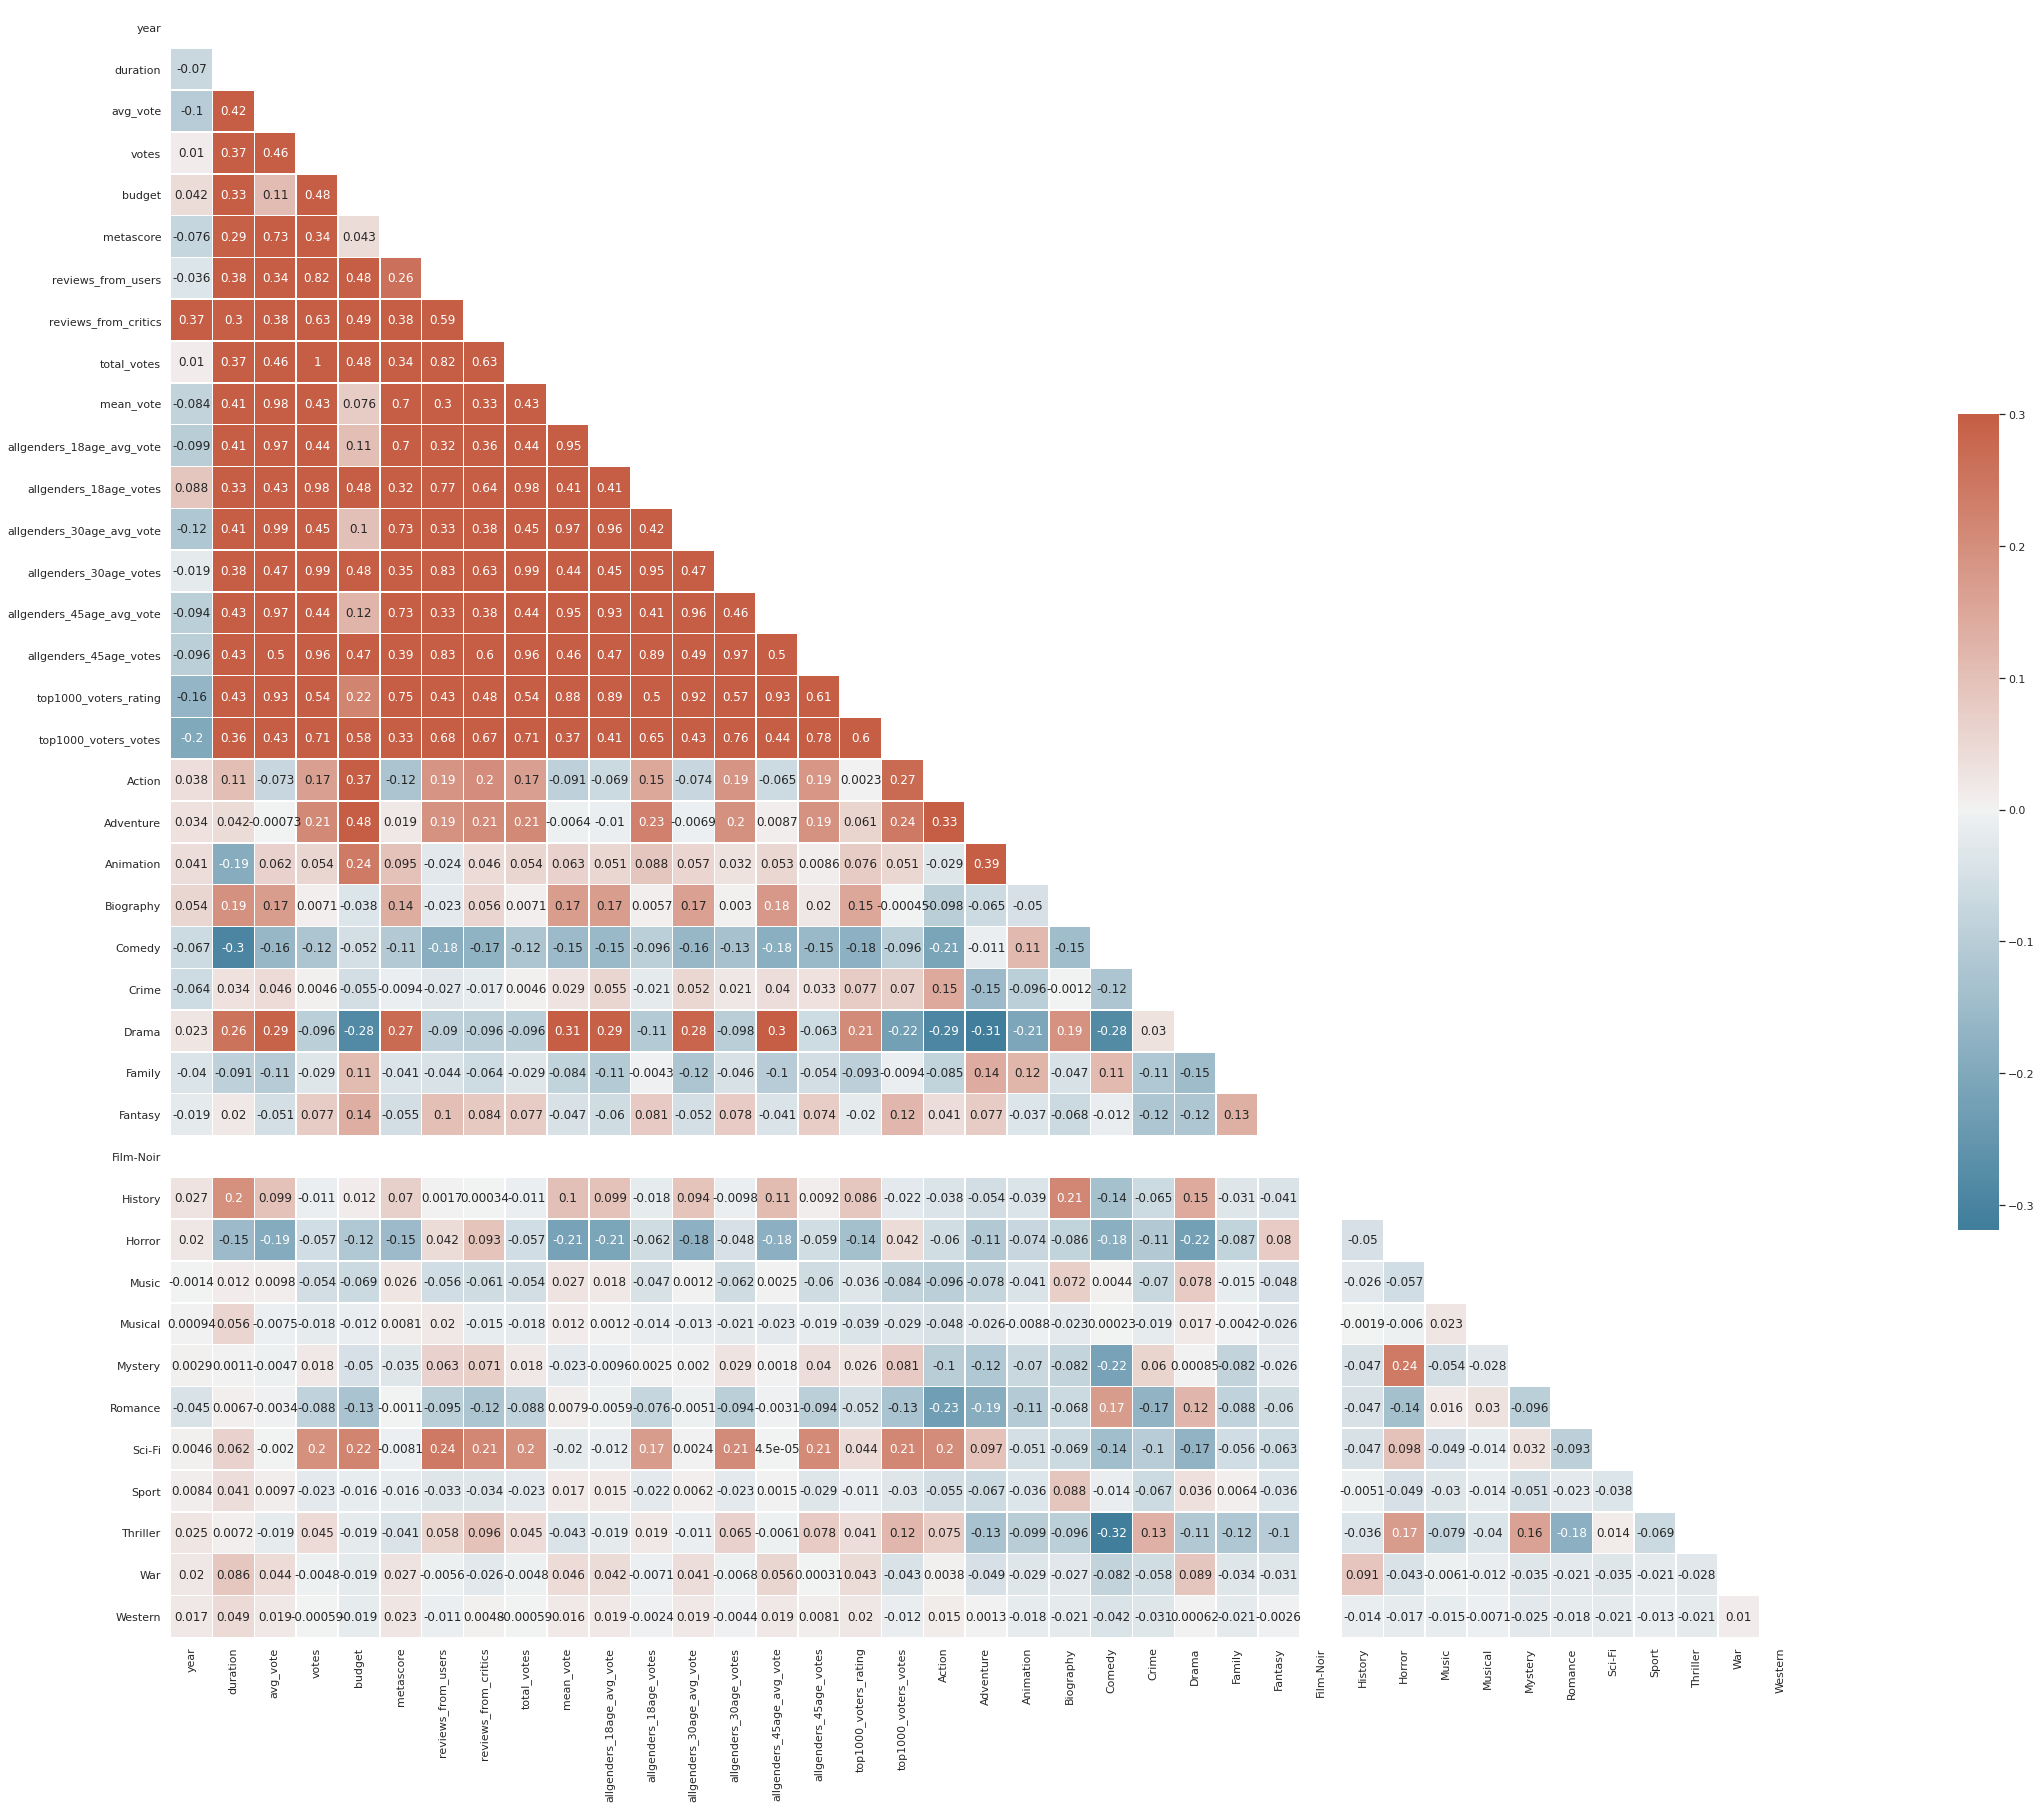

In [6]:
tr.corr()
corr = tr.corr()
sn.set_theme(style = "white")
print(corr)
mask = np.triu(np.ones_like(corr))
f, ax = plt.subplots(figsize=(50, 30))
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

year                               10.00
duration                           22.00
avg_vote                            1.30
votes                           98586.50
budget                       34000000.00
metascore                          26.00
reviews_from_users                265.25
reviews_from_critics              142.00
total_votes                     98586.50
mean_vote                           1.30
allgenders_18age_avg_vote           1.20
allgenders_18age_votes          23514.25
allgenders_30age_avg_vote           1.30
allgenders_30age_votes          44446.25
allgenders_45age_avg_vote           1.20
allgenders_45age_votes          10602.75
top1000_voters_rating               1.30
top1000_voters_votes              343.00
Action                              0.00
Adventure                           0.00
Animation                           0.00
Biography                           0.00
Comedy                              1.00
Crime                               0.00
Drama           

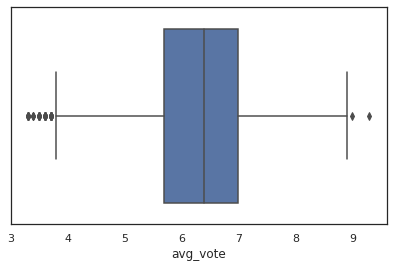

In [7]:
Q1 = tr.quantile(0.25)
Q3 = tr.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
train = tr.avg_vote[(np.abs(stats.zscore(tr.avg_vote)) < 3)]
sn.boxplot(train)

## Creating the Confusion Matrix Template  
In this section we create our primary target variable named "hitflop".  
Here we take our metascore values and classify them into 3 types - unsuccessful, mediocre and successful movies

In [8]:
hitflop1 = pd.cut(tr.metascore,bins=[0,33,66,100],labels=[0,1,2])
hitflop1 = hitflop1.to_numpy()
hitflop2 = pd.cut(te.metascore,bins=[0,33,66,100],labels=[0,1,2])
hitflop2 = hitflop2.to_numpy()

## Simple Linear Regression  
We use this model to predict the metascore values of the movies which will be used in the probability test defined above. We use the top 1000 voter ratings attribute in the SLR model as follows

In [11]:
arr1_SLR = np.array(tr['top1000_voters_rating']).reshape((-1, 1))
arr2_SLR = np.array(tr['metascore'])
model1_SLR = LinearRegression().fit(arr1_SLR, arr2_SLR)
model1_SLR.score(arr1_SLR, arr2_SLR)

0.5561476127550706

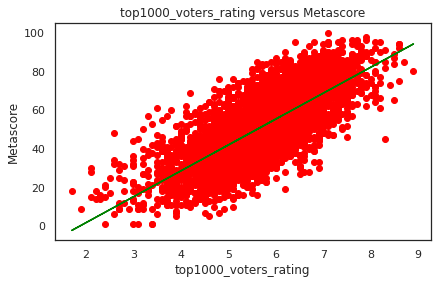

In [14]:
x_test_SLR = np.array(te['top1000_voters_rating']).reshape((-1, 1)) #Creating a new array from the new_movies list between 2005 to 2015. This is for both x and y
y_test_SLR = np.array(te['metascore'])
y_pred_SLR = model1_SLR.predict(arr1_SLR)
plt.scatter(arr1_SLR, arr2_SLR, color = "red")
plt.plot(arr1_SLR, y_pred_SLR, color = "green")
plt.title("top1000_voters_rating versus Metascore")
plt.xlabel("top1000_voters_rating")
plt.ylabel("Metascore")
plt.show()

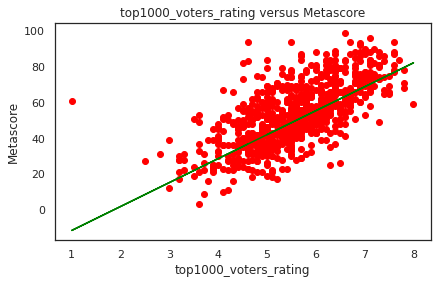

In [17]:
y_pred_1 = model1_SLR.predict(x_test_SLR)
p=pd.cut(y_pred_1,bins=[0,33,66,100],labels=[0,1,2])
p=p.fillna(0)
p=p.to_numpy()
p
plt.scatter(x_test_SLR, y_test_SLR, color = "red")
plt.plot(x_test_SLR, y_pred_1, color = "green")
plt.title("top1000_voters_rating versus Metascore")
plt.xlabel("top1000_voters_rating")
plt.ylabel("Metascore")
plt.show()

In [19]:
# import sklearn
y_pred_bin = pd.cut(y_pred_SLR,bins=[-3,33,66,100],labels=[0,1,2])
y_pred_bin = y_pred_bin.to_numpy()
slr_acc = sklearn.metrics.accuracy_score(hitflop1,y_pred_bin)
slr_acc

0.7099666388657214

## Multiple Linear Regression  
In this model we use more than a single attribute, in this case being the addition of the below listed attributes, to plot the regression line and predict the corresponding metascore values.  
The accuracy is then calculated in the same way as done above using the confusion matrix method.

In [20]:
X = tr[['budget', 'reviews_from_users', 'reviews_from_critics', 'top1000_voters_rating', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']] 
Y = tr['metascore']
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -19.436391376845712
Coefficients: 
 [-7.67155204e-08 -1.80435287e-03  2.65319950e-02  1.24763748e+01
 -3.29612050e+00  9.65795044e-01  4.56771338e+00 -1.36839856e+00
 -9.68954432e-01 -2.63068405e+00  2.58197506e+00  2.12200304e+00
 -2.11137330e+00  0.00000000e+00 -8.29062002e-01 -3.79760058e+00
  2.30957358e+00  5.16768956e+00 -3.33467880e+00 -7.53911499e-01
 -4.16854303e-01 -2.46865754e+00 -2.38928716e+00 -2.38115862e+00
  5.02094177e-02]


In [21]:
regr.score(X,Y)

0.620303236632112

In [22]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
#print(vif_data["VIF"])
vif_data

,feature,VIF
0,budget,3.407902
1,reviews_from_users,2.687091
2,reviews_from_critics,4.539561
3,top1000_voters_rating,17.954329
4,Action,2.006688
5,Adventure,2.082188
6,Animation,1.443603
7,Biography,1.293783
8,Comedy,2.640407
9,Crime,1.573650


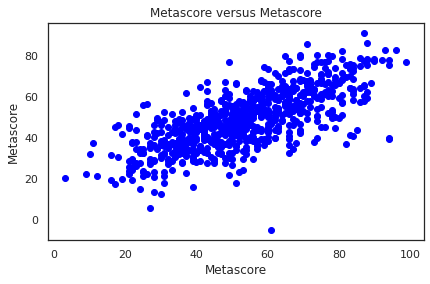

In [23]:
X_testing = te[['budget', 'reviews_from_users', 'reviews_from_critics', 'top1000_voters_rating', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']]
Y_testing = te['metascore']
test_final = regr.predict(X_testing)
regr.score(X_testing, te['metascore'])
plt.scatter(Y_testing, test_final, color = 'blue')
#plt.plot(te['metascore'], test_final, color = "green")
plt.title("Metascore versus Metascore")
plt.xlabel("Metascore")
plt.ylabel("Metascore")
plt.show()

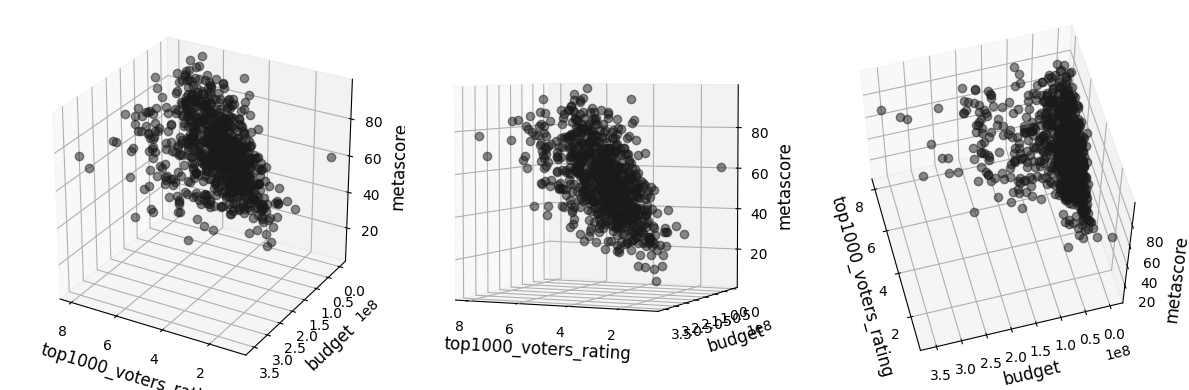

In [24]:
x_mlr = X_testing['top1000_voters_rating']
y_mlr = X_testing['budget']
z_mlr = Y_testing
plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]
for ax in axes:
    ax.plot(x_mlr, y_mlr, z_mlr, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.set_xlabel('top1000_voters_rating', fontsize=12)
    ax.set_ylabel('budget', fontsize=12)
    ax.set_zlabel('metascore', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.tight_layout()

In [25]:
# import sklearn
k = sklearn.metrics.mean_squared_error(te['metascore'], test_final)
k ** 0.5
min(te['metascore'])

3.0

### Probability testing for MLR
As mentioned before, we use the confusion matrix method to perform our accuracy testing on the model here.

In [26]:
k=pd.cut(te.metascore,bins=[0,33,66,100],labels=[0,1,2])
p=pd.cut(test_final,bins=[0,33,66,100],labels=[0,1,2])
p=p.fillna(0)
p=p.to_numpy()
r=k.to_numpy()
sklearn.metrics.confusion_matrix(r,p)
sklearn.metrics.accuracy_score(r,p)
sklearn.metrics.precision_score(r,p,average=None)

array([0.53061224, 0.72535211, 0.78350515])

## K-Means Classifier
The K means classifier here classifies the given data into three clusters as taken by the hitflop ratios.  

In [29]:
X=te[['budget', 'reviews_from_users', 'reviews_from_critics',
         'top1000_voters_rating',
       'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']]
kmeans = KMeans(n_clusters=3, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(X)

In [30]:
hitflop2 = pd.cut(te.metascore,bins=[0,33,66,100],labels=[0,1,2])
cm=sklearn.metrics.classification_report(hitflop2,y_kmeans)
print(cm)

              precision    recall  f1-score   support

           0       0.06      0.04      0.05       101
           1       0.61      0.75      0.67       479
           2       0.16      0.09      0.12       183

    accuracy                           0.50       763
   macro avg       0.28      0.29      0.28       763
weighted avg       0.43      0.50      0.46       763



In [31]:
hitflop2 = pd.cut(te.metascore,bins=[0,33,66,100],labels=[0,1,2])
cm1=sklearn.metrics.confusion_matrix(hitflop2,y_kmeans)
print(cm1)
(kmeans.labels_).shape

[[  4  89   8]
 [ 36 360  83]
 [ 25 141  17]]


(763,)

Now we plot the kmeans clusters that have been created. 

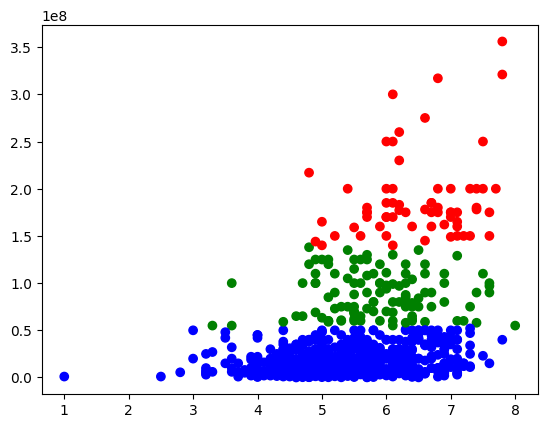

In [32]:
color=['red','blue','green']
label_color = [color[l] for l in kmeans.labels_]
plt.scatter(te['top1000_voters_rating'],te['budget'] ,c=label_color)

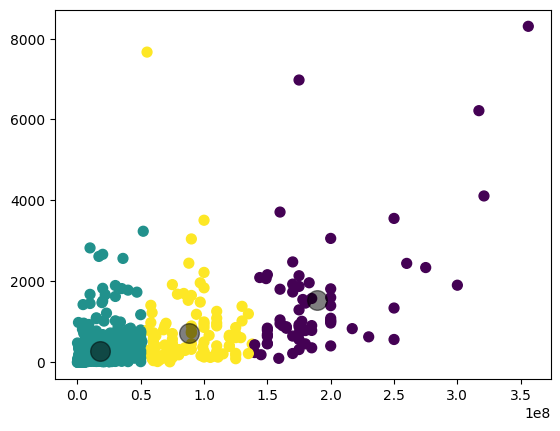

In [33]:
X_Kmeans = X.to_numpy()
plt.scatter(X_Kmeans[:, 0], X_Kmeans[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Logistic Regression
It uses the data given to it to split it into a success or a failure.

In [34]:
x_tr_log =tr[['top1000_voters_rating' ,'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']]
x_te_log = te[['top1000_voters_rating' ,'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']]

In [35]:
hitflop1_log = pd.cut(tr.metascore,bins=[0,50,100],labels=[0,1])
hitflop1_log = hitflop1_log.to_numpy()
hitflop2_log = pd.cut(te.metascore,bins=[0,50,100],labels=[0,1])
hitflop2_log = hitflop2_log.to_numpy()
y_tr_log = hitflop1_log
y_te_log = hitflop2_log

In [36]:
# from sklearn.linear_model import LogisticRegression 
classifier = LogisticRegression(random_state = 0) 
classifier.fit(x_tr_log, y_tr_log) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We now plot the confusion matrix to determine the accuracy of the model

In [38]:
y_pred_lr = classifier.predict(x_te_log) 
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_te_log, y_pred_lr) 
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[297  42]
 [147 277]]


In [39]:
# from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_te_log, y_pred_lr)) 

Accuracy :  0.7522935779816514


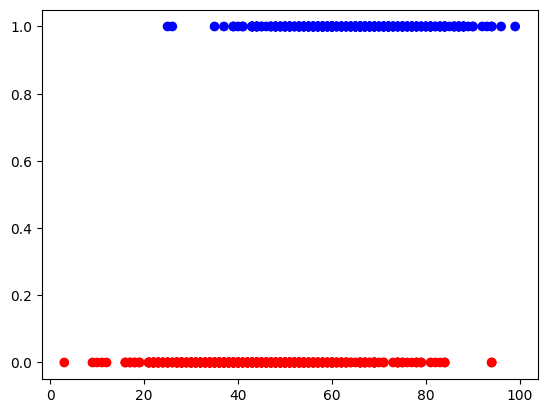

In [40]:
color=['red','blue']
label_color = [color[l] for l in y_pred_lr]
plt.scatter(te['metascore'], y_pred_lr ,c=label_color)

In [41]:
vif_data_lr = pd.DataFrame()
vif_data_lr["feature"] = x_tr_log.columns
# calculating VIF for each feature
vif_data_lr["VIF"] = [variance_inflation_factor(x_tr_log.values, i) for i in range(len(x_tr_log.columns))]
#print(vif_data["VIF"])
vif_data_lr

,feature,VIF
0,top1000_voters_rating,13.817065
1,Action,1.900670
2,Adventure,1.935462
3,Animation,1.380864
4,Biography,1.278264
5,Comedy,2.475966
6,Crime,1.557316
7,Drama,4.084583
8,Family,1.183086
9,Fantasy,1.208259


## Ridge Regression
Here we apply a ridge model that applies a correction on the OLS method and executes  

In [42]:
#from sklearn.linear_model import Ridge
x_train_ridge = tr[['budget', 'reviews_from_users', 'reviews_from_critics', 'top1000_voters_rating', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']]
y_train_ridge = tr['metascore']
x_test_ridge = te[['budget', 'reviews_from_users', 'reviews_from_critics', 'top1000_voters_rating', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western']]
y_test_ridge = te['metascore']
model_ridge = Ridge(alpha=1150)
model_ridge.fit(x_train_ridge, y_train_ridge)

Ridge(alpha=1150, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

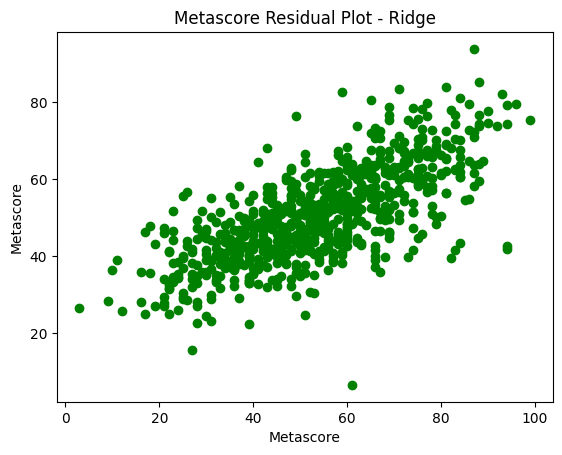

In [43]:
yhat = model_ridge.predict(x_test_ridge)
plt.scatter(y_test_ridge, yhat, color = 'green')
plt.title("Metascore Residual Plot - Ridge")
plt.xlabel("Metascore")
plt.ylabel("Metascore")
plt.show()

In [44]:
model_ridge.score(x_test_ridge, y_test_ridge)

0.48551407636754207

Calculating the accuracy through a confusion matrix

In [45]:
p_ridge = pd.cut(yhat, bins=[0,33,66,100], labels=[0,1,2])
p_ridge = p_ridge.fillna(0)
p_ridge=p_ridge.to_numpy()
p_ridge

array([1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,

In [46]:
print(sklearn.metrics.classification_report(hitflop2,p_ridge))

              precision    recall  f1-score   support

           0       0.67      0.29      0.40       101
           1       0.71      0.94      0.81       479
           2       0.83      0.38      0.52       183

    accuracy                           0.72       763
   macro avg       0.74      0.54      0.58       763
weighted avg       0.73      0.72      0.69       763



## LASSO Regression
Similar to ridge in performing the correction in OLS and estimating the values

In [47]:
# from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha = 0.145)
model_lasso.fit(x_train_ridge, y_train_ridge)
yhat_lasso = model_lasso.predict(x_test_ridge)

In [48]:
model_lasso.score(x_test_ridge, y_test_ridge)

0.4600612577638753

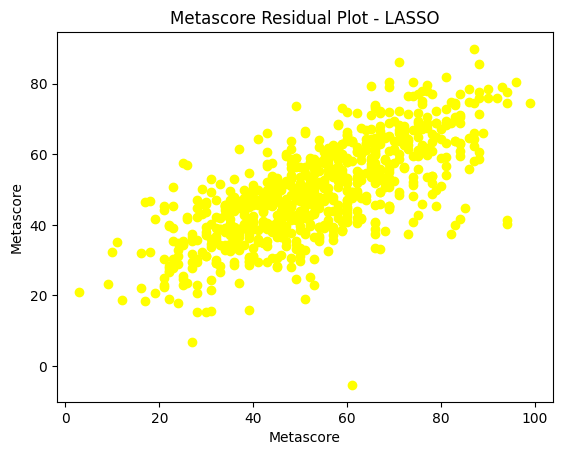

In [49]:
model_lasso.score(x_test_ridge, y_test_ridge)
plt.scatter(y_test_ridge, yhat_lasso, color = 'yellow')
plt.title("Metascore Residual Plot - LASSO")
plt.xlabel("Metascore")
plt.ylabel("Metascore")
plt.show()

Dividing into bins to calculate the accuracy

In [50]:
p_lasso = pd.cut(yhat_lasso, bins=[0,33,66,100], labels=[0,1,2])
p_lasso = p_lasso.fillna(0)
p_lasso=p_lasso.to_numpy()
p_lasso

array([1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2,
       1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,

In [51]:
print(sklearn.metrics.classification_report(hitflop2,p_lasso))    

              precision    recall  f1-score   support

           0       0.60      0.49      0.54       101
           1       0.73      0.89      0.80       479
           2       0.80      0.40      0.54       183

    accuracy                           0.72       763
   macro avg       0.71      0.59      0.63       763
weighted avg       0.73      0.72      0.70       763



## Support Vector Machine - SVM
Classifies the data by dividing it using n planes on n-dimensions

In [52]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(tr[['top1000_voters_rating', 'Action']],hitflop1)
y_pred = svclassifier.predict(te[['top1000_voters_rating', 'Action']])

In [53]:
from sklearn.metrics import classification_report  
print(confusion_matrix(hitflop2,y_pred))
print(classification_report(hitflop2,y_pred))

[[ 38  63   0]
 [ 27 433  19]
 [  0 116  67]]
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       101
           1       0.71      0.90      0.79       479
           2       0.78      0.37      0.50       183

    accuracy                           0.71       763
   macro avg       0.69      0.55      0.58       763
weighted avg       0.71      0.71      0.68       763



## Time Series Analysis
Here we use the **SARIMAX** model to predict values and forecast them to give us values through almost 4 years

In [54]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [55]:
tr_ts = tr[['date_published', 'metascore']]
tr_ts.isnull().sum()
tr_ts = tr_ts.groupby('date_published')['metascore'].sum().reset_index()
tr_ts

,date_published,metascore
0,1990-01-12,30.0
1,1990-01-19,65.0
2,1990-01-25,61.0
3,1990-03-09,121.0
4,1990-04-06,98.0
...,...,...
2054,2016-11-18,24.0
2055,2016-12-29,26.0
2056,2017-01-10,41.0
2057,2017-04-14,39.0


In [56]:
tr_ts = tr_ts.set_index('date_published')
tr_ts.index

Index(['1990-01-12', '1990-01-19', '1990-01-25', '1990-03-09', '1990-04-06',
       '1990-04-20', '1990-05-04', '1990-05-11', '1990-06-01', '1990-07-11',
       ...
       '2016-09-09', '2016-09-29', '2016-09-30', '2016-10-07', '2016-10-21',
       '2016-11-18', '2016-12-29', '2017-01-10', '2017-04-14', '2017-12-15'],
      dtype='object', name='date_published', length=2059)

In [57]:
tr_ts.index = pd.to_datetime(tr_ts.index, unit='ns')
y_r = tr_ts['metascore'].resample('MS').mean()
y_r.dropna 

<bound method Series.dropna of date_published
1990-01-01     52.0
1990-02-01      NaN
1990-03-01    121.0
1990-04-01     78.0
1990-05-01     43.5
              ...  
2017-08-01      NaN
2017-09-01      NaN
2017-10-01      NaN
2017-11-01      NaN
2017-12-01     63.0
Freq: MS, Name: metascore, Length: 336, dtype: float64>

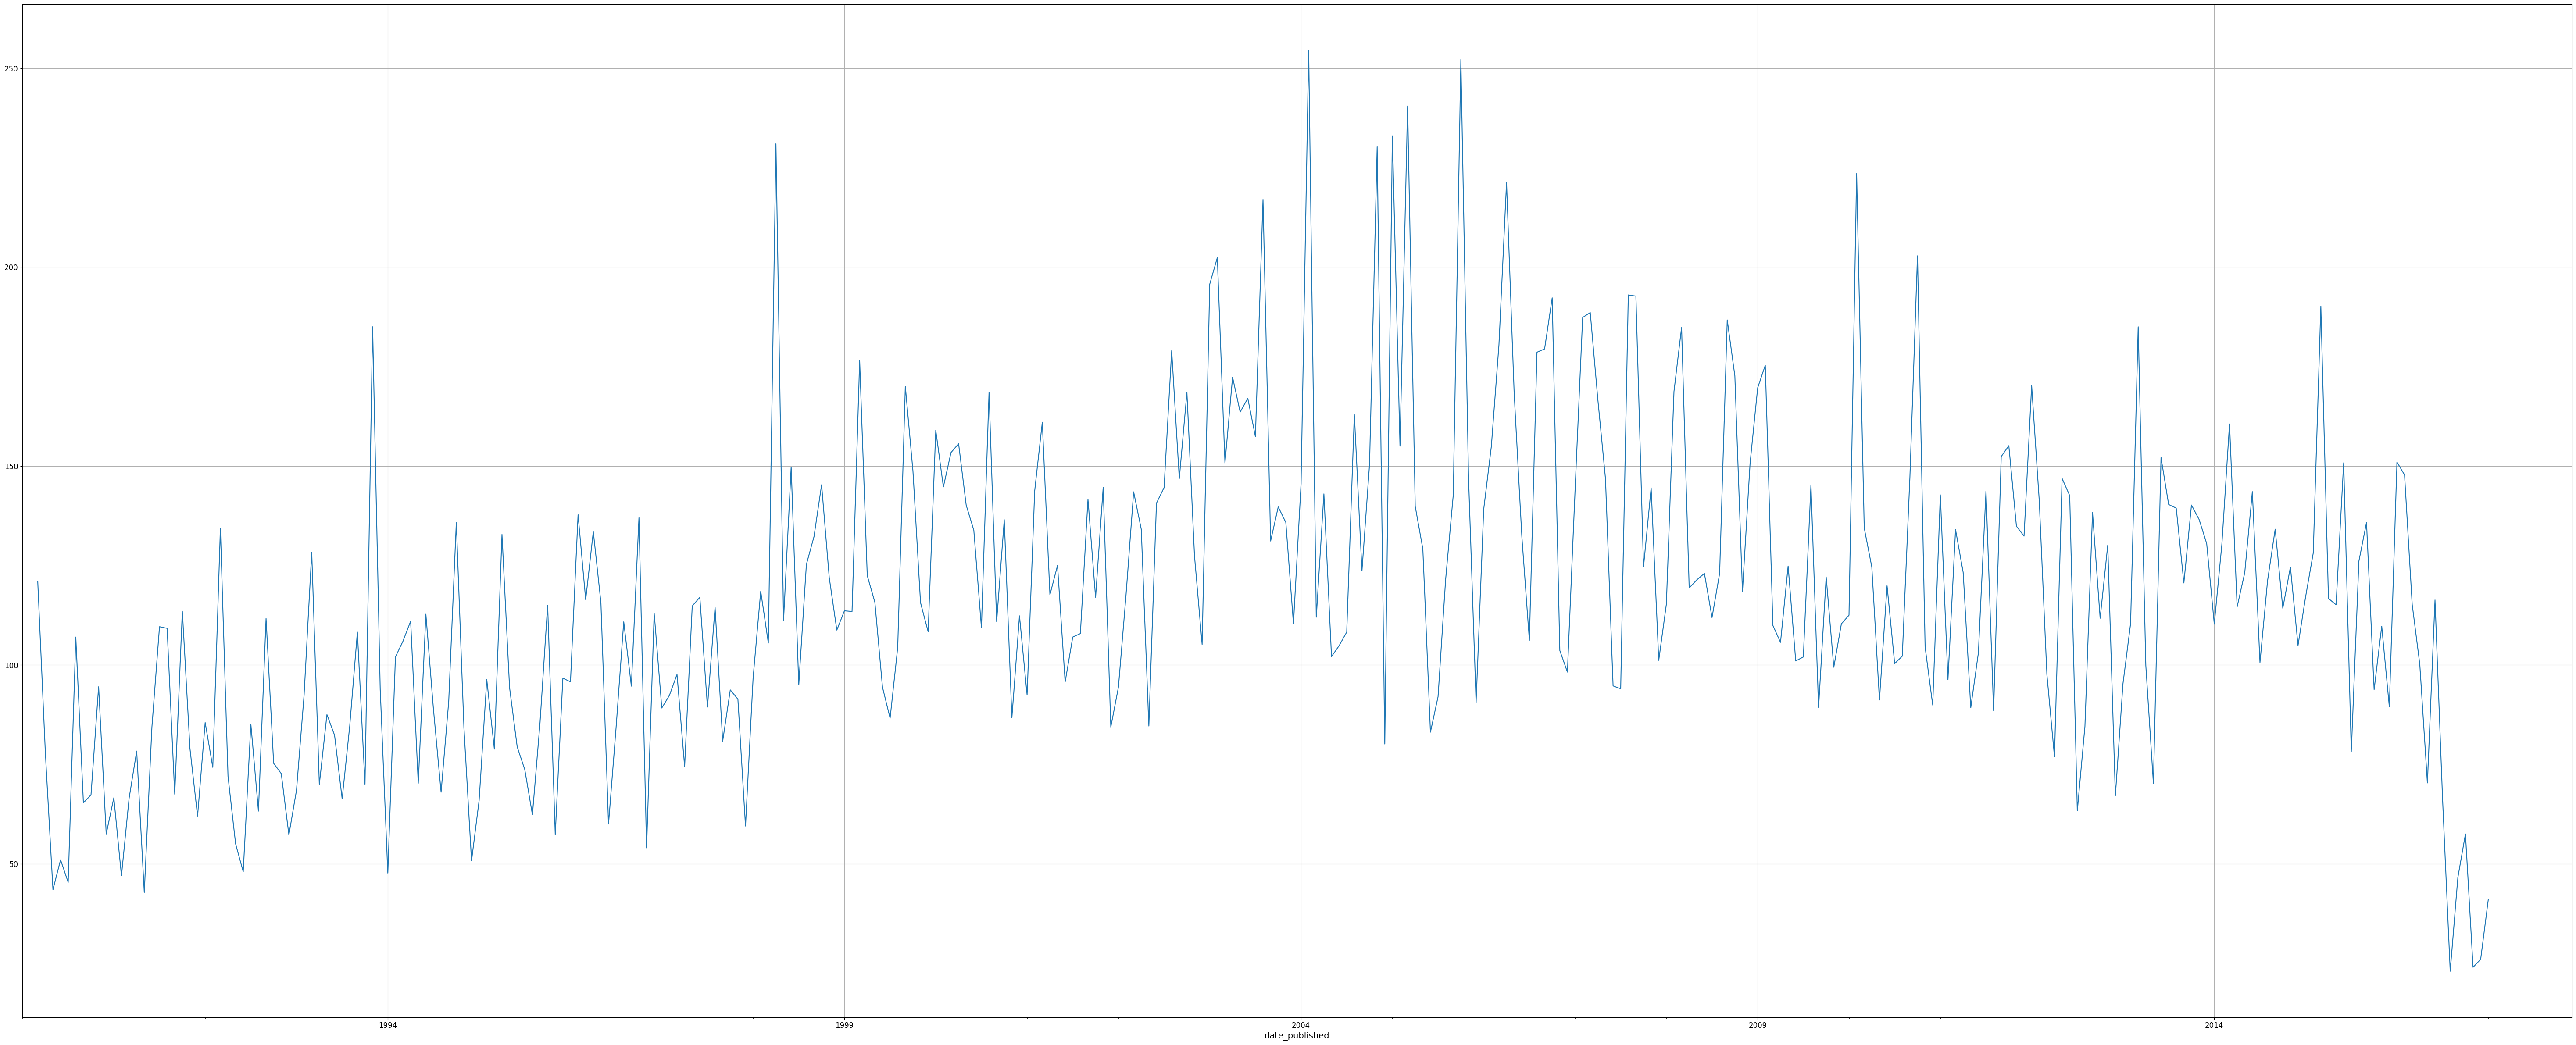

In [58]:
y_r.plot(figsize=(75, 30), grid = True)
plt.show()

From the above we can see that the data shows minimal seasonality, but show peaks during certain seasons for each year. Also, we can see that most good movies were released between 1997 - 2011 as they have the highest scores

In [59]:
y_r.mean()
y_r.fillna(116.96944585748261)
for i in y_r:
  if i == 'NaN':
    i = 116.96944585748261

In [60]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [61]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_r, order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4057.7505614842967
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3667.1234567695183
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3256.480436141279
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3037.2073322811275
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3258.8207245964722
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3163.6610027788824
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3080.2246374211372
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3039.1247185762677
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3793.9777203070385
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3528.8515311776005
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3241.869491865624
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3020.792013334996
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3258.701240728602
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3243.633204302111
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3079.4218044330173
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3022.6720776517222
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3373.9827074864666
SARIMAX(0, 1, 0)x(0

In [62]:
mod = sm.tsa.statespace.SARIMAX(y_r,order=(0, 1, 1),seasonal_order=(0, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8642      0.030    -28.906      0.000      -0.923      -0.806
ma.S.L12      -1.0948      0.056    -19.593      0.000      -1.204      -0.985
sigma2       873.2264     98.435      8.871      0.000     680.297    1066.156


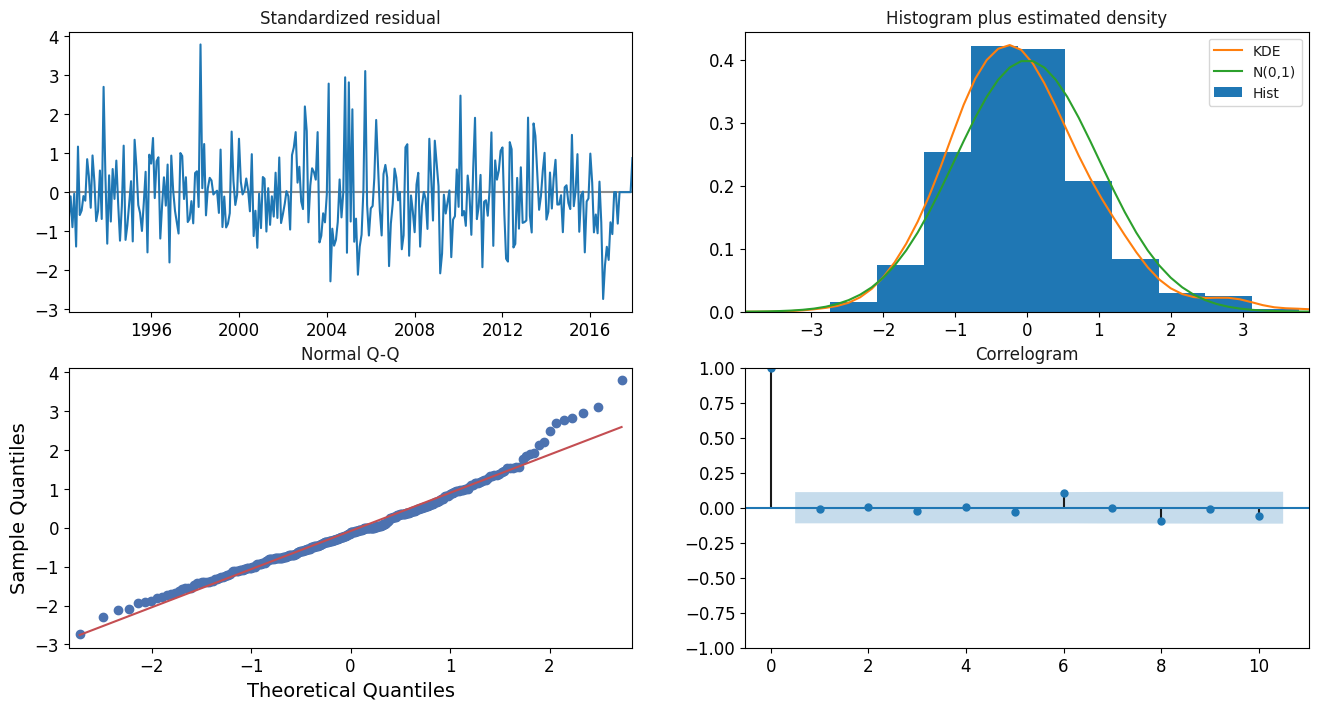

In [63]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

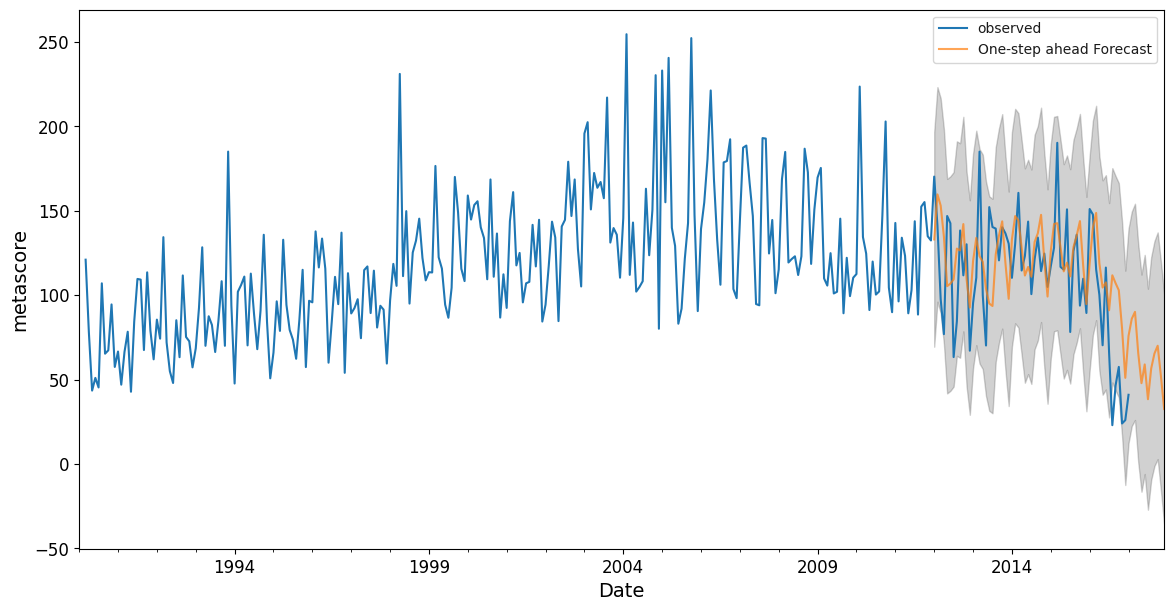

In [64]:
pred = results.get_prediction(pd.to_datetime('2012-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_r['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('metascore')
plt.legend()
plt.show()

In [65]:
y_forecasted = pred.predicted_mean
y_truth = y_r['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of the forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of the forecast is 910.34


In [66]:
print('The Root Mean Squared Error of the forecast is {}'.format(round(np.sqrt(mse), 2)))
results.summary()

The Root Mean Squared Error of the forecast is 30.17


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          metascore   No. Observations:                  336
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1476.127
Date:                            Sun, 29 Nov 2020   AIC                           2958.254
Time:                                    17:32:13   BIC                           2969.454
Sample:                                01-01-1990   HQIC                          2962.731
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8642      0.030    -28.906      0.000      -0.923      -0.806
ma.S.L12      -1.0948      0.056    -19.593      0.000      -1.204      -0.985
sigma2       873.2264     98.435      8.871      0.000     680.297    1066.156
===================================================================================
Ljung-Box (Q):                       25.23   Jarque-Bera (JB):                32.62
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.61
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

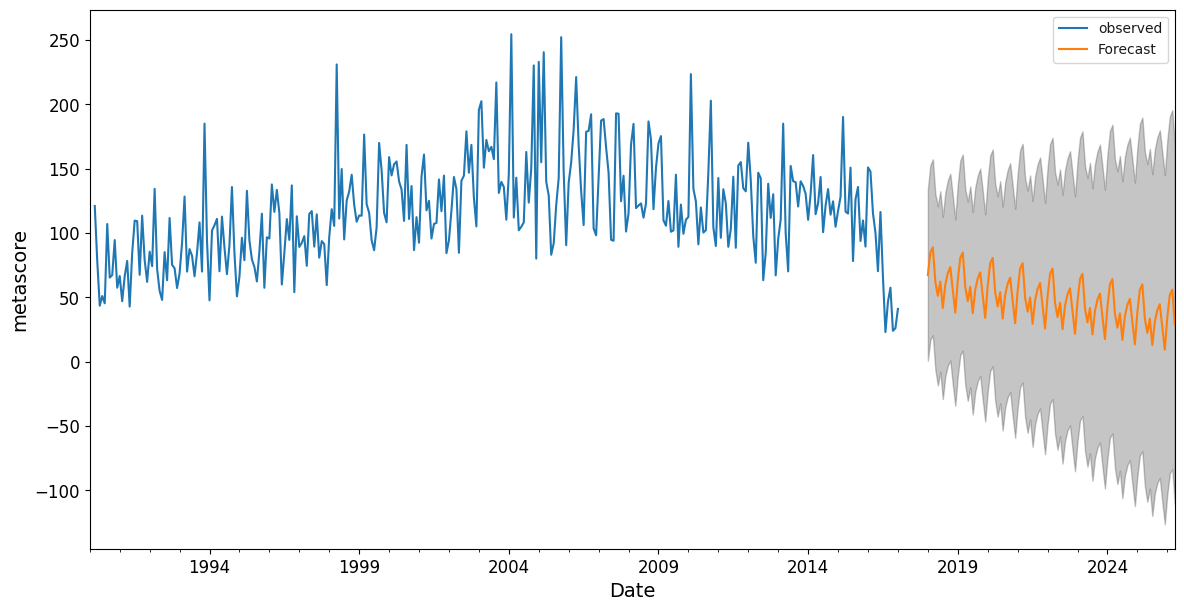

In [67]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y_r.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('metascore')
plt.legend()
plt.show()

# We hence come to the end of our project here